# Training Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist = False
cifar10 = True
cifar100 = False
assert mnist ^ cifar10 ^ cifar100

n_classes = 10
if mnist:
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
if cifar10:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
if cifar100:
    n_classes = 100
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    if len(x_grey.size()) == 3:
        helper = torch.unsqueeze(x_grey, 1)
        return helper.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 1:
        return x_grey.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 3:
        return x_grey
    elif len(x_grey.size()) == 4:
        raise ValueError(f'The size of this image tensor is not valid.\
        A 4th order image tensor must have dim1==1 (grey-scale) or dim1==3 (rgb).\
        Unknown format cannot be transformed to rgb.')
    else:
        raise ValueError(f'The size of this image-tensor is not valid.\
        Must be either 3rd (grey-scale) order tensor or 4th order tensor (rgb).\
        Got order {len(x_grey.size())}')
        
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

if mnist:
    X_train_grey = trainset.train_data
    X_train = to_rgb(X_train_grey)
    X_test_grey = testset.test_data
    X_test = to_rgb(X_test_grey)
    y_train = trainset.train_labels
    y_test = testset.test_labels
else:
    X_train = torch.tensor(swap_data(trainset.data))
    y_train = torch.tensor(trainset.targets)
    X_test = torch.tensor(swap_data(testset.data))
    y_test = torch.tensor(testset.targets)
    
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


## Model load, modifications and GPU optimization

In [4]:
from torchvision import models

'''
model = models.resnet18(pretrained=False) # set model here
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
'''

# redefining stuff for AdaSecant test runs
X_train = torch.rand(256, 10)
X_test = torch.rand(256, 10)
y_train = torch.randint(10, (256,))
y_test = torch.randint(10, (256,))

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

model = torch.nn.Sequential(nn.Linear(10, 10), nn.Linear(10, 10))
for param in model.parameters():
    print(param)

dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

X_train: torch.Size([256, 10])
y_train: torch.Size([256])
X_test: torch.Size([256, 10])
y_test: torch.Size([256])
Parameter containing:
tensor([[ 1.4078e-02, -3.9616e-02, -7.2260e-02, -2.5270e-01,  9.7713e-02,
          2.8178e-04, -8.0032e-02,  4.4090e-02, -1.8610e-02,  1.8555e-01],
        [ 1.0932e-01, -8.4304e-02,  1.4666e-01,  3.1359e-01, -1.4992e-01,
          2.8736e-01, -2.1158e-01, -1.3150e-02, -2.0706e-01,  2.2609e-01],
        [-6.4325e-02,  8.4393e-02, -1.8449e-02, -2.3070e-01, -2.3148e-01,
          1.8885e-01,  4.8048e-02, -5.1638e-02, -2.8709e-01,  7.3048e-02],
        [-7.6229e-02,  1.8433e-01,  2.6976e-01, -2.4699e-01, -1.1053e-01,
          1.6059e-03, -2.4282e-01,  1.7602e-01,  9.2398e-03, -1.5417e-01],
        [ 1.4938e-01,  5.1420e-02, -7.1059e-02,  2.4362e-01,  3.1580e-01,
         -2.9684e-01, -2.7441e-02, -3.1564e-01, -2.1313e-01,  2.4051e-01],
        [-4.7556e-03,  2.3492e-01,  2.5702e-01,  2.0029e-01,  2.9431e-01,
          1.6840e-01, -3.1040e-02,  3.7002e-0

Check specs for GPU-based training.

In [5]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


## Implementing AdaSecant
https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

In [16]:
from typing import List

class AdaSecant():

    def __init__(self, params):
        self.params = params
        self.gradients = self.get_gradients()
    
    
    @torch.no_grad()
    def get_gradients(self):
        d_p_list = []
        for p in self.params:
            print('ok')
            # subgrouping of parameters for each layer, bias and weights separately (each tensor)
            if p.grad is not None:
                d_p_list.append(p.grad)
        return d_p_list


    @torch.no_grad()
    def step(self):
        params_with_grad = []
        next_gradients = []
        for p in self.params:
            print('hello')
            # subgrouping of parameters for each layer, bias and weights separately (each tensor)
            if p.grad is not None:
                params_with_grad.append(p)
                next_gradients.append(p.grad)
                
            adasecant(params_with_grad, self.gradients, next_gradients)
            
        return #loss
    
def adasecant(params: List[torch.Tensor], gradients: List[torch.Tensor], next_gradients: List[torch.Tensor]):
    print(gradients)
    # d_p_list[i] corresponds to param[i]
    for i, param in enumerate(params):
        g = d_p_list[i]
    pass

In [21]:
import itertools
from more_itertools import peekable

def adasecant_dataloader(dataset, batch_size, shuffle=False, drop_last=False):
    data_loader = peekable(iter(data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)))
    return data_loader

data_loader = adasecant_dataloader(dataset_test, 60, True, True)
for batch in data_loader:
    print('current', batch['y'])
    try:
        peek = data_loader.peek()
        print('next', peek['y'])
    except StopIteration:
        pass

current tensor([5, 9, 7, 8, 4, 8, 4, 9, 0, 2, 1, 6, 7, 1, 5, 4, 6, 6, 8, 5, 7, 9, 7, 5,
        1, 1, 0, 9, 5, 9, 7, 2, 8, 5, 7, 0, 3, 7, 1, 1, 8, 6, 8, 0, 3, 7, 2, 1,
        1, 0, 7, 8, 8, 5, 1, 5, 5, 6, 8, 5])
next tensor([1, 0, 7, 6, 0, 3, 9, 8, 8, 3, 8, 3, 3, 6, 9, 6, 0, 4, 9, 7, 1, 5, 1, 2,
        6, 4, 4, 5, 3, 4, 3, 2, 9, 9, 3, 6, 3, 9, 3, 4, 5, 7, 9, 2, 9, 5, 1, 1,
        4, 1, 7, 4, 9, 1, 6, 4, 6, 0, 0, 2])
current tensor([1, 0, 7, 6, 0, 3, 9, 8, 8, 3, 8, 3, 3, 6, 9, 6, 0, 4, 9, 7, 1, 5, 1, 2,
        6, 4, 4, 5, 3, 4, 3, 2, 9, 9, 3, 6, 3, 9, 3, 4, 5, 7, 9, 2, 9, 5, 1, 1,
        4, 1, 7, 4, 9, 1, 6, 4, 6, 0, 0, 2])
next tensor([9, 5, 8, 8, 4, 9, 2, 4, 2, 9, 3, 6, 3, 5, 8, 7, 4, 2, 2, 2, 2, 3, 5, 0,
        0, 9, 1, 7, 3, 5, 0, 6, 3, 1, 8, 1, 3, 9, 0, 4, 9, 6, 5, 8, 1, 1, 9, 5,
        7, 7, 0, 9, 9, 1, 1, 6, 4, 6, 7, 2])
current tensor([9, 5, 8, 8, 4, 9, 2, 4, 2, 9, 3, 6, 3, 5, 8, 7, 4, 2, 2, 2, 2, 3, 5, 0,
        0, 9, 1, 7, 3, 5, 0, 6, 3, 1, 8, 1, 3, 9, 0, 4, 9, 6, 5, 8

## Training

In [18]:
def evaluate_model(model, dataset, batch_size=1000):
    
    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    loss = 0.0
    correct = 0
    
    for batch in data_loader:
        yhat = model.forward(batch['X'].float().to(device))
        y = batch['y'].long().to(device)
        batch_loss = f_loss(yhat, y)
        loss += batch_loss.item() * len(batch['X'])
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().item()
    accuracy = correct / len(dataset)
    
    return loss, accuracy

def get_scheduler(optimizer, base_lr, max_lr, epochs_per_cycle, len_dataset, batch_size):
    if epochs_per_cycle is None:
        epochs_per_cycle = epochs
    iterations_per_cycle = epochs_per_cycle * (len_dataset // batch_size)
    return torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=iterations_per_cycle / 2)

In [19]:
def train_model(model, dataset, validation_set, batch_size=64, epochs=1, 
                f_loss=F.cross_entropy, epochs_per_cycle=None):
    
    optimizer = AdaSecant(model.parameters())
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []
    
    # evaluate initial state of model
    initial_training_loss, _ = evaluate_model(model, dataset)
    epoch_losses.append(initial_training_loss)
    validation_loss, accuracy = evaluate_model(model, validation_set)
    validation_losses.append(validation_loss)
    validation_accuracy.append(accuracy)

    for epoch in range(epochs):
        # training and epoch loss logging
        # drop last to avoid stochastic outliers in gradient update
        data_loader = adasecant_dataloader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0
        for batch in data_loader:            
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item() * len(batch['X'])
            batch_loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataset)}')
        epoch_losses.append(epoch_loss)
        
        # calculate validation loss and accuracy
        validation_loss, accuracy = evaluate_model(model, validation_set)
        validation_losses.append(validation_loss)
        validation_accuracy.append(accuracy)
        
    return (np.array(epoch_losses) / len(dataset), 
            np.array(validation_losses) / len(validation_set), 
            validation_accuracy, 
            lr_history)

In [20]:
base_lr = 0.01
max_lr = 0.1
batch_size = 16
epochs = 1
f_opt = AdaSecant
f_loss = F.cross_entropy
cycle = epochs

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device),
                                                                              dataset_train,
                                                                              dataset_test,
                                                                              batch_size,
                                                                              epochs,
                                                                              f_loss,
                                                                              cycle)

ok
ok
ok
ok
Epoch 1/1 - Loss: 2.3112996369600296


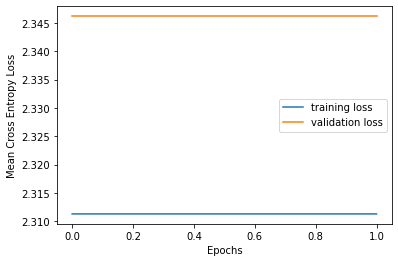

In [12]:
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

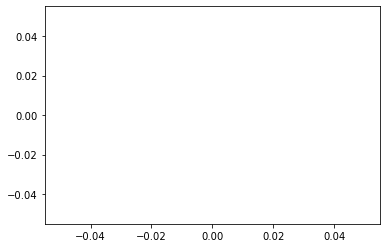

In [13]:
plt.plot(lr_history)

0.0625


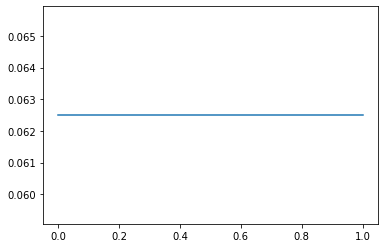

In [14]:
plt.plot(validation_accuracy)
print(max(validation_accuracy))

In [15]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'